## Exercício 1

Siga o tutorial do site [Physics-informed Neural Networks: a simple tutorial with PyTorch](https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a). Neste exemplo, você irá resolver a EDO do resfriamento de uma caneca de café em etapas:

1. Resolva analiticamente a EDO do resfriamento de uma caneca de café. A equação é dada por:

```math
   \frac{dT}{dt} = r(T_{amb} - T)
```
onde $T$ é a temperatura do café, $T_{amb} = 25$ ºC é a temperatura ambiente e $r = 0.005$ $s^{-1}$ é uma taxa de resfriamento.

2. Resolva a EDO usando o método de Runge-Kutta de quarta ordem (RK4) e compare com a solução analítica. Use o comando `scipy.integrate.solve_ivp`.

3. Usando a solução analítica, ou RK4, gere dados sintéticos para treinar a PINN. Cerca de 10 pontos no intervalo de 0 a 200 segundos (veja exemplo no tutorial). Some um ruído gaussiano com média 0 e desvio padrão 0.5 em cada ponto.

4. Tente usar uma NN de regressão simples para ajustar os dados sintéticos e extrapolar para tempos maiores (até 1000 segundos). Compare com a solução analítica. Sabemos que a extrapolação será péssima.

5. Agora, siga o tutorial e implemente a PINN incluindo as restrições físicas na minimização da perda, mas assumindo que conhecemos o valor da taxa $r = 0.005$ 1/s. Compare com a solução analítica e com a NN de regressão simples.

6. Ainda seguindo o tutorial, implemente a PINN sem conhecer o valor da taxa $r$. A rede deve ser capaz de descobrir o valor correto. Compare com a solução analítica e com a NN de regressão simples.

In this notebook, I explore different approaches to solving ordinary differential equations (ODEs): analytical methods, numerical methods, traditional neural networks, and PINNs. The goal is to compare how each method incorporates physical knowledge of the problem, handles extrapolation, and enables the discovery of unknown parameters.

In [5]:
import numpy as np
import tensorflow as tf

The code above creates a time interval and a set of evaluation points that the ODE solver will use to calculate the temperature numerically. It also computes the analytical solution for comparison, and both results are plotted to visualize and compare the trends from the numerical and analytical methods.

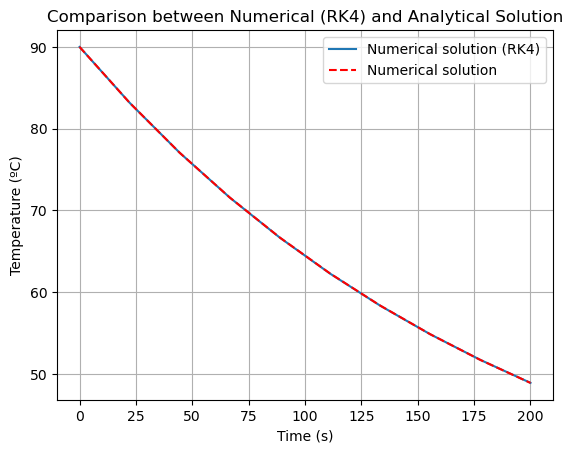

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Defining the ODE: dT/dt = r * (T_amb - T)
def cooling(t, T, r=0.005, T_amb=25):
    return r * (T_amb - T)

# Initial condition and time
T0 = 90
t_interval = (0, 200)  # Time interval
t_eval = np.linspace(0, 200, 10)  # Evaluation points

# Solving the ODE with the Runge-Kutta solver
solution = solve_ivp(cooling, t_interval, [T0], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label="Numerical solution (RK4)")

# Analytical solution
T_analyt = 25 + (T0 - 25) * np.exp(-0.005 * solution.t)
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Comparison between Numerical (RK4) and Analytical Solution")
plt.grid(True)
plt.show()



The neural network model is designed to learn the temperature function $T(t)$. The code above generates points representing the time input, calculates the temperature for each point and its gradient. After the ODE is calculated, the MSE is generated. For this case, the cooling rate ($r$) is given as $R$.

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        grads = tape.gradient(outputs, inputs)
    return grads

def physics_loss(model, R, Tenv):
    """The physics loss of the model."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  
    time = tf.Variable(time, trainable=True)  

    # Run the collocation points through the network
    temperature = model(time)

    # Get the gradient
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Compute the ODE
    ode = dT - R * (Tenv - temperature)

    # MSE of ODE
    return tf.reduce_mean(tf.square(ode))

In this approach, the cooling rate $r$ is treated as an unknown parameter that the network will attempt to discover during training. The physical loss is computed by generating a set of time points, predicting the corresponding temperatures, and then calculating the gradient of temperature with respect to time.

In [ ]:
class Net(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        # Make r a trainable variable
        self.r = tf.Variable(0.0, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        # Define the forward pass (to be implemented based on your architecture)
        pass

def physics_loss_discovery(model, Tenv):
    """Physics loss for discovering the parameter r."""
    # Create collocation points
    time = tf.linspace(0, 1000, num=1000)[:, tf.newaxis]  # Shape (1000, 1)
    time = tf.Variable(time, trainable=True)  # Ensure `ts` is differentiable

    # Run the collocation points through the network
    temperature = model(time)

    # Compute the gradient of temps with respect to ts
    with tf.GradientTape() as tape:
        tape.watch(time)
        dT = tape.gradient(temperature, time)

    # Use the differentiable parameter r
    residue_ode = model.r * (Tenv - temperature) - dT

    # Return the mean squared error of the PDE residual
    return tf.reduce_mean(tf.square(residue_ode))

Generating synthetic data with noise:

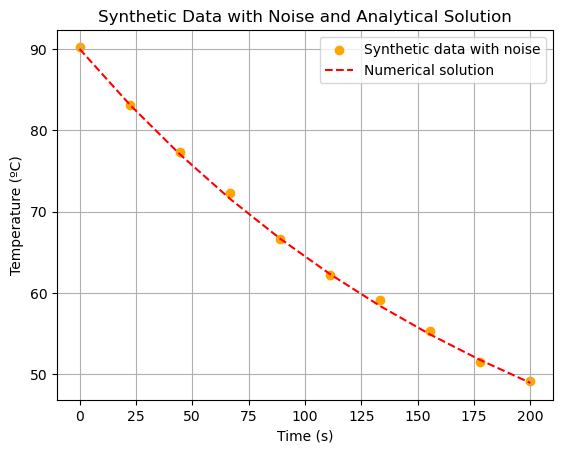

In [8]:
np.random.seed(42)
synthetic_data = T_analyt + np.random.normal(0, 0.5, size=len(solution.t))

plt.scatter(solution.t, synthetic_data, label="Synthetic data with noise", color='orange')
plt.plot(solution.t, T_analyt, '--', label="Numerical solution", color='red')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (ºC)")
plt.legend()
plt.title("Synthetic Data with Noise and Analytical Solution")
plt.grid(True)
plt.show()


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - loss: 4618.6924
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4618.5586
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4618.4253
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 4618.2920
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4618.1587
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4618.0249
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4617.8921
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4617.7588
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4617.6250
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4617.4912
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4617.3584
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4617.2241
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4617.0913
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4616.9580
Epoch 15/1000
1/1 ━━━━━━━━━

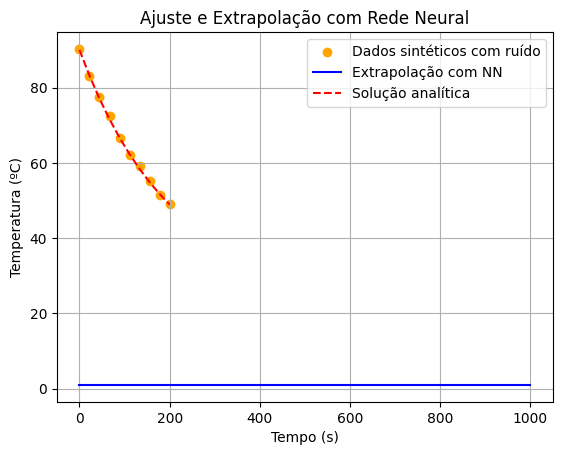

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Convertendo os dados para tensores
X_train = tf.convert_to_tensor(solution.t.reshape(-1, 1), dtype=tf.float32)
y_train = tf.convert_to_tensor(synthetic_data.reshape(-1, 1), dtype=tf.float32)

# Definindo a arquitetura da rede neural
model = models.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(2, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mse')

# Treinando a rede
model.fit(X_train, y_train, epochs=1000, verbose=True)

# Extrapolando a rede neural
X_test = np.linspace(0, 1000, 1000).reshape(-1, 1)
y_pred = model.predict(X_test)

# Plotando a previsão da rede neural
plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, y_pred, label="Extrapolação com NN", color='blue')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Ajuste e Extrapolação com Rede Neural")
plt.grid(True)
plt.show()

Epoch [0/1000], Loss: 22677.0273
Epoch [100/1000], Loss: 1845.5632
Epoch [200/1000], Loss: 1801.3597
Epoch [300/1000], Loss: 1755.6399
Epoch [400/1000], Loss: 1702.7385
Epoch [500/1000], Loss: 1639.9188
Epoch [600/1000], Loss: 1562.0663
Epoch [700/1000], Loss: 1461.8717
Epoch [800/1000], Loss: 1331.2577
Epoch [900/1000], Loss: 1165.4208


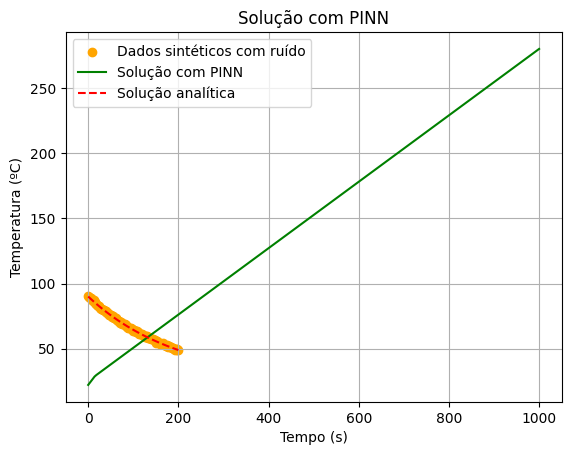

In [ ]:
class PINN(tf.keras.Model):
    def __init__(self, r=0.005):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(10, activation='relu', input_dim=1)
        self.dense2 = layers.Dense(1)
        self.r = r  # Taxa de resfriamento fixa

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return t

    def physics_loss(self, t, T):
        # Calculando a derivada de T em relação a t
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Calculando a perda física (restrição)
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss

# Inicializando e treinando a PINN
model_pinn = PINN(r=0.005)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Treinando a PINN
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn(X_train)
        loss = tf.reduce_mean(tf.square(T_pred - y_train)) + model_pinn.physics_loss(X_train, T_pred)
    grads = tape.gradient(loss, model_pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")

# Plotando a solução da PINN
T_pinn = model_pinn(X_test).numpy()
plt.scatter(solution.t, synthetic_data, label="Dados sintéticos com ruído", color='orange')
plt.plot(X_test, T_pinn, label="Solução com PINN", color='green')
plt.plot(solution.t, T_analyt, '--', label="Solução analítica", color='red')

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (ºC)")
plt.legend()
plt.title("Solução com PINN")
plt.grid(True)
plt.show()


In [ ]:
class PINN_r_unknown(tf.keras.Model):
    def __init__(self):
        super(PINN_r_unknown, self).__init__()
        self.dense1 = layers.Dense(10, activation='relu', input_dim=1)
        self.dense2 = layers.Dense(1)
        self.r = tf.Variable(0.005, dtype=tf.float32, trainable=True)  # r é agora uma variável treinável

    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        return t

    def physics_loss(self, t, T):
        # Calculando a derivada de T em relação a t
        with tf.GradientTape() as tape:
            tape.watch(t)
            T_pred = self.call(t)
        dTdt = tape.gradient(T_pred, t)
        T_amb = 25
        # Calculando a perda física (restrição) com o valor de r treinável
        loss = tf.reduce_mean(tf.square(dTdt - self.r * (T_amb - T_pred)))
        return loss

# Inicializando e treinando a PINN
model_pinn_r_unknown = PINN_r_unknown()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Treinando a PINN
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_pred = model_pinn_r_unknown(X_train)
        loss = tf.reduce_mean(tf.square(T_pred - y_train)) + model_pinn_r_unknown.physics_loss(X_train, T_pred)
    grads = tape.gradient(loss, model_pinn_r_unknown.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_pinn_r_unknown.trainable_variables))

SyntaxError: incomplete input (3566642718.py, line 38)